## Семинар 9: "LSTM"[SOLVED]

ФИО:Курбанов Ринат

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
from torch.nn.utils.rnn import pack_sequence,pad_packed_sequence
import torch
import sys
from torch import nn
from torch.autograd import Variable
import pandas
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from torch.optim.lr_scheduler import StepLR
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [32]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            print(inp.shape, self.W_i.shape)
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

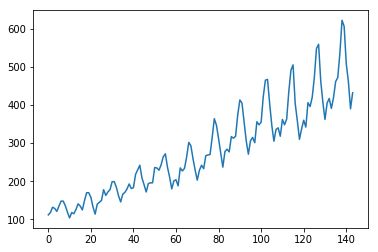

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [6]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [10]:
# Пример подготовленных данных

look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

#trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [11]:
trainX[0]

array([0.01544401, 0.02702703, 0.05405405, 0.04826255, 0.03281853],
      dtype=float32)

In [12]:
trainY[0]

0.059845567

In [13]:
class PassengerDataset(Dataset):
    def __init__(self, trainX, trainY):
        self.trainX = trainX
        self.trainY = trainY

    def __len__(self):
        return len(self.trainY)

    def __getitem__(self, idx):
        return self.trainX[idx], self.trainY[idx]
    
train_dataset = PassengerDataset(trainX, trainY)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64)

test_dataset = PassengerDataset(testX, testY)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [14]:
train_dataset[0]

(array([0.01544401, 0.02702703, 0.05405405, 0.04826255, 0.03281853],
       dtype=float32), 0.059845567)

In [15]:
def generate(model, n, inputs, batch_first=True):
    result = np.zeros(n + len(inputs))
    result[:len(inputs)] = inputs
    inp = 0
    for i in range(n):
        if batch_first:
            inp = Variable(torch.FloatTensor(result[i:i+len(inputs)])).view(1, len(inputs), 1)
        else:
            inp = Variable(torch.FloatTensor(result[i:i+len(inputs)])).view(len(inputs), 1, 1)
        res = lstm(inp)
        result[i + len(inputs)] = res[-1].cpu().data.numpy()
    return result

In [28]:
dtype=torch.FloatTensor

def trains( network, sh,learning_rate, epochs=1600, loss=nn.MSELoss(), optim=torch.optim.Adam, my=True):
    train_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, 1)
    try:
        for i in range(sh):
            for epoch in range(epochs):
                losses = []
                accuracies = []
                for X,Y in train_dataloader:
                    if my:
                        X = Variable(X.permute(1,0).unsqueeze(-1))
                        Y = Variable(Y)
                        #print(X[0])
                        prediction = network(X).squeeze()
                        #print(Y[0],prediction[0])
                    else:
                        X = Variable(torch.FloatTensor(X)).view(-1, look_back, 1)
                        Y = Variable(torch.FloatTensor(Y)).view(-1, 1)
                        prediction = network(X)
                    loss_batch = loss(prediction, Y)
                    losses.append(loss_batch.item())
                    optimizer.zero_grad()
                    loss_batch.backward()
                    optimizer.step()
  
                train_loss_epochs.append(np.mean(losses))
                losses = []    
            scheduler.step()
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.9f}'.format(
                        i, train_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [33]:
class myLSTMModel(nn.Module):
    def __init__(self, hidden_dim):
        super(myLSTMModel, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = LSTM(1, hidden_dim)

        self.hidden2out = nn.Sequential(nn.Linear(hidden_dim, 1))

    def forward(self, inp):
        seq_length = inp.size(0)
        batch_size = inp.size(1)
        hidden = (Variable(torch.zeros(batch_size, self.hidden_dim)),
                  Variable(torch.zeros(batch_size, self.hidden_dim)))
        
        lstm_out, self.hidden = self.lstm(inp, hidden)
        lstm_out = lstm_out[-1]
        
        out = self.hidden2out(lstm_out.view(batch_size, self.hidden_dim))
        return out

In [36]:
lstm = myLSTMModel(8)

In [37]:
trains(lstm,3,1e-1)

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) 

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) 

torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])

torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) 

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
Epoch 0... (Train/Test) MSE: 0.000413388torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1])

torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])

torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])

torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) 

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1])

torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1])

torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) 

torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) 

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1])

torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1])

torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1])

torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])


torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([64, 1]) torch.Size([1, 32])
torch.Size([26, 1]) torch.Size([1, 32])


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



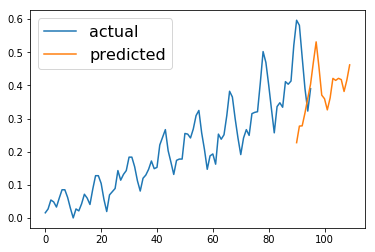

In [20]:
seq = train.reshape(-1)
start = 0
plength = 90
blength = 20
base =  seq[start:start+blength]
predicted = generate(lstm, plength, base, batch_first=0)
actual = seq[start:start+plength+blength]
plt.plot(actual, label='actual')
plt.plot(range(plength,plength+blength),predicted[plength:], label='predicted')
plt.legend(fontsize=16);

In [399]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(1, hidden_dim, num_layers=num_layers)

        self.hidden2out = nn.Sequential(nn.Linear(hidden_dim, 1))

    def forward(self, inp):
        seq_length = inp.size(1)
        batch_size = inp.size(0)
        hidden = (Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)),
                  Variable(torch.zeros(self.num_layers, batch_size, self.hidden_dim)))
        inp = pack_sequence(inp)
        
        lstm_out, self.hidden = self.lstm(inp, hidden)
        lstm_out, _ = pad_packed_sequence(lstm_out)
        lstm_out = lstm_out[-1]
        
        out = self.hidden2out(lstm_out.view(batch_size, self.hidden_dim))
        return out

Epoch 5... (Train/Test) MSE: 0.000003418

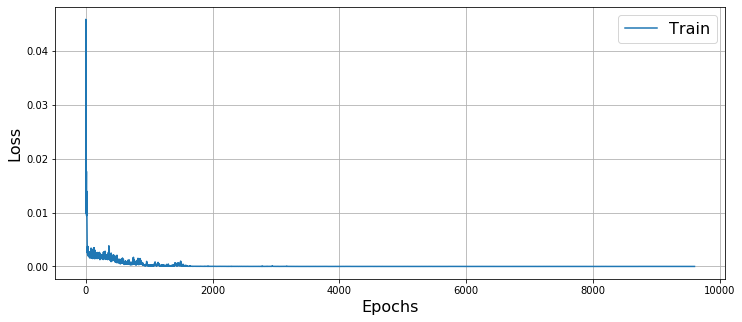

In [405]:
lstm = LSTMModel(8, 1)
trains(lstm,6,1e-1, my=False)

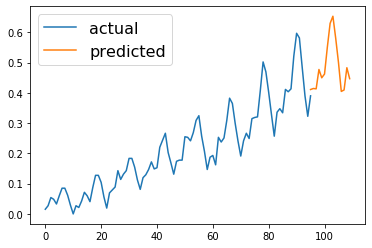

In [406]:
seq = train[:,0]
start = 0
plength = 90
blength = 20
base =  seq[start:start+blength]
predicted = generate(lstm, plength, base)
actual = seq[start:start+plength+blength]
plt.plot(actual, label='actual')
plt.plot(range(95,110),predicted[95:], label='predicted')
plt.legend(fontsize=16)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: